Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz
Epoch: 0010 cost= 112.542405215         

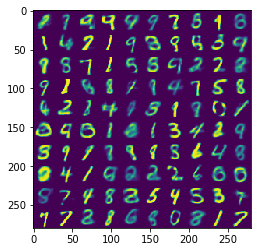

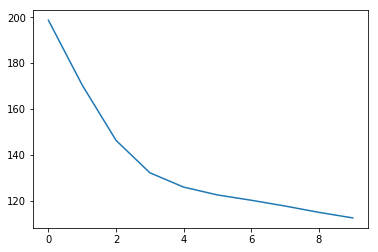

In [1]:
from vae import *
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

# Define the identity function
def identity(x):
    return x

# Set up the network architecture
arch = dict()
arch['encoder'] = [\
    ('fc', identity, 784, -1), \
    ('fc', tf.nn.softplus, 500, 784), \
    ('fc', tf.nn.softplus, 500, 500), \
    ('fc', identity, 20, 500), \
    ('fc', identity, 20, 500) \
    ]
arch['decoder'] = [\
    ('fc', tf.nn.softplus, 500, 20), \
    ('fc', tf.nn.softplus, 500, 500), \
    ('fc', tf.nn.sigmoid, 784, 500) \
    ]
arch['input_shape'] = [784]
arch['first_roll_shape'] = (-1, -1, -1)

# Initialize the variational autoencoder
batch_size = 100
learning_rate = 1e-3
vae = VAE(arch, learning_rate, batch_size)

# Set up the data
mnist = input_data.read_data_sets('data/mnist/')

# Run the autoencoder
n_samples = mnist.train.num_examples
total_batch = int(n_samples/batch_size)
n_epochs = 100
display_step = 1

costs = []
for epoch in range(n_epochs):
    avg_cost = 0.0
    for batch in range(total_batch):
        x, _ = mnist.train.next_batch(batch_size)
        cost = vae.train(x)
        avg_cost += (cost - avg_cost) / (batch + 1)
    costs.append(avg_cost)

    if epoch % display_step == 0:
        print "\rEpoch:", '%04d' % (epoch+1), \
                "cost=", "{:.9f}".format(avg_cost),

# Generate sample images
z = np.random.normal(size=(batch_size, 20))
generated_images = vae.generate_image(z)

# Show generated images
big_image = np.zeros((280, 280))
for i in range(10):
    for j in range(10):
        n = i*10 + j
        big_image[28*i:28*(i+1), 28*j:28*(j+1)] = np.reshape(generated_images[n, :], (28, 28))

plt.imshow(big_image)
plt.show()

# Show cost vs epoch plot
plt.plot(costs)
plt.show()

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz
Batch: 550 of 550 Epoch: 0001 cost= 238.103183094                                                                                                             
Batch: 550 of 550 Epoch: 0002 cost= 188.956061873                           215 of 550          550              of 550                           of 550                          550       550      
Batch: 550 of 550 Epoch: 0003 cost= 168.436027000                                                                          550               407 of 550                              of 550       
Batch: 550 of 550 Epoch: 0004 cost= 157.349347590550                                  550                             358 of 550                                                
Batch: 550 of 550 Epoch: 0005 cost= 149.864899375                            

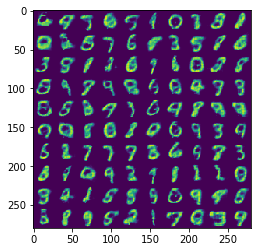

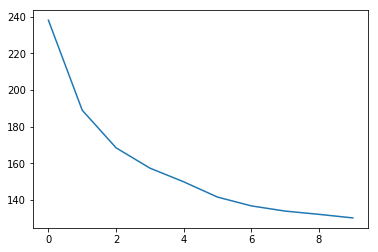

In [1]:
from vae import *
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 100
learning_rate = 1e-3

# Define the identity function
def identity(x):
    return x

# Set up the network architecture
arch = dict()
arch['encoder'] = [\
    ('fc', identity, 784, -1), \
    ('conv', tf.nn.relu, 5, 1, 8), \
    ('conv', tf.nn.relu, 3, 8, 16), \
    ('pool', identity, 4), \
    ('fc', tf.nn.relu, 500, 784), \
    ('fc', identity, 20, 500), \
    ('fc', identity, 20, 500) \
    ]
arch['decoder'] = [\
    ('fc', tf.nn.relu, 500, 20), \
    ('fc', tf.nn.relu, 784, 500), \
    ('tconv', tf.nn.relu, 3, 16, 8, (batch_size, 14, 14, 8), (1, 2, 2, 1)), \
    ('tconv', tf.nn.sigmoid, 3, 8, 1, (batch_size, 28, 28, 1), (1, 2, 2, 1))
    ]
arch['input_shape'] = [28, 28, 1]
arch['first_roll_shape'] = (7, 7, 16)

# Initialize the variational autoencoder
vae = VAE(arch, learning_rate, batch_size)

# Set up the data
mnist = input_data.read_data_sets('data/mnist/')

# Run the autoencoder
n_samples = mnist.train.num_examples
total_batch = int(n_samples/batch_size)
n_epochs = 10
display_step = 1

costs = []
for epoch in range(n_epochs):
    avg_cost = 0.0
    for batch in range(total_batch):
        x, _ = mnist.train.next_batch(batch_size)
        x = np.reshape(x, (batch_size, 28, 28, 1))
        cost = vae.train(x)
        avg_cost += (cost - avg_cost) / (batch + 1)    
        print "\rBatch:", '%03d' % (batch+1), "of" , '%03d' % total_batch,
    costs.append(avg_cost)

    if epoch % display_step == 0:
        print "Epoch:", '%04d' % (epoch+1), \
                "cost=", "{:.9f}".format(avg_cost)

# Generate sample images
z = np.random.normal(size=(batch_size, 20))
generated_images = vae.generate_image(z)

# Show generated images
big_image = np.zeros((280, 280))
for i in range(10):
    for j in range(10):
        n = i*10 + j
        big_image[28*i:28*(i+1), 28*j:28*(j+1)] = np.reshape(generated_images[n, :], (28, 28))

plt.imshow(big_image)
plt.show()

# Show cost vs epoch plot
plt.plot(costs)
plt.show()